## New York City Airbnb Open Data - Exploratory Data Analysis

**By: Vishnu Rangiah**

vishnu.rangiah@gmail.com

### Introduction

Airbnb is a platform that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities. Airbnb is accessible through website or mobile app. 

In this report we will be analyzing Airbnb data from the Airbnb Open Data New York City 2019 data set. 
The data we are currently analyzing comes from: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data. Through this dataset, we can get information regarding hosts, geographical availability and necessary metrics needed to make predictions and draw conclusions. 

We will be performing our analysis using Python. In *Section 1*, we will be cleaning, and preforming exploratory data analysis on the data. Then we will explore the relationship between the names of each listing and the popularity of the listing using Natural Language Processing Methods in *Section 2*.

[//]: # (We will be cleaning, and preforming exploratory analysis on the data. 
Then we will explore the realtionship between the Names of each listing and the popularity of the listing using Natural Language Processing Methods.)


***NEXT STEPS: EDA, NLP, CONCLUSION***

### Importing Libraries 

In [2]:
# importing packages

# data manipulation
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import geopandas as gpd
import contextily as ctx

# string manipulation
import re
import more_itertools as more
impoert string

SyntaxError: invalid syntax (4045673512.py, line 18)

### Loading Dataset

In [4]:
df = pd.read_csv("datasets/AB_NYC_2019.csv")

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
# columns and data types
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Here we find that our dataset contains 48,895 rows which represent individual listings in New York. We are also provided with 16 different metrics which contain necessary information about a particular listing.  

### Summary Statistics

In [7]:
df.describe().iloc[:,2:]

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


From the summary statistics of our dataset we find that the max *price* seems abnormally high at \\$10,000 as well as the min price of $0 which is supposed to indicate the nightly cost of a single Airbnb listing. The min *availability_365* or availability of a listing in the calendar year is 0 days which is also abnormal since listings typically should be available at least once in a year. Interestingly the total count for reviews_per_month has about 10,000 less listings than the other metrics this may occur due to null values. We will further inspect these listings when performing data cleaning and try to deduce the reason for these seemingly abnormal values. It is also evident that our longitude, latitude values both seem to fall within a partiular range which do not appear to have outliers.  

*Note*: We have chosen to omit *id* and *host_id* from the summary statistics because they do not provide insights. In this analysis we use borough and neighborhood group interchangeably.

### Data Cleaning  

#### Outline of Data Cleaning 

1. Find null values
    - Look for negative values
2. Get rid of listings that have zero availability (*avalibility_365*) 
    - *avalibility_365* :  number of days the property is available for rent in 2019
    - The Airbnb calendar does not differentiate between a booked night v.s. an unavailable night. This serves to understate the availability metric because popular listings will be "booked" rather than being "blacked out" by a host.
3. Get rid of listings that have zero *number_of_reviews*
4. Get rid of listings that have *last_review* before 2016
5. Get rid of listings that are too expensive 

    
*Additional Information about metrics were provided by the Open Airbnb Data documentation.*


#### Null Values 

In [8]:
# checking for null values
df.isnull().sum().sort_values(ascending=False) 

last_review                       10052
reviews_per_month                 10052
host_name                            21
name                                 16
id                                    0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

There are **null values** in the *name*, *host_name*, *last_review*, and *reviews_per_month* columns. We will omit the listings with null values below. Before omiting we would like to observe the other metrics in the dataset.

#### Listings with Zero Availability

In [9]:
# listings with 0 avaliable nights
df[df.availability_365 == 0].head() 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
14,6090,West Village Nest - Superhost,11975,Alina,Manhattan,West Village,40.73530,-74.00525,Entire home/apt,120,90,27,2018-10-31,0.22,1,0
20,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,2011-12-28,0.07,1,0


In [10]:
# total number of listings with 0 availability
df[df.availability_365 == 0].shape

(17533, 16)

The dataframe above consists of listings with zero availability. This could potentially be because the host did not want to rent the listing on the website, the listing was fully booked, or Airbnb suspended the listing. We will omit these listing since we aim to analyze listings available to users on the Airbnb marketplace in 2019 in NYC.  

#### Listings with Zero Reviews

In [11]:
# listings with 0 total reviews
df[df.number_of_reviews == 0].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365


In [12]:
# total number of listings with 0 number of reviews
df[df.number_of_reviews == 0].shape

(10052, 16)

In [13]:
# observing listings with no reviews and no availability
df_noreview = df[df.number_of_reviews == 0]
df_noreview[df_noreview.availability_365 == 0].shape

(4845, 16)

The dataframe above consists of listings with 0 *number_of_reviews*. We chose to omit these listings from the dataset because the number of reviews of a listing can indicate if the listing was active during 2019. Since these listing have no reviews we are assuming that they were inactive. It is also shown above that nearly half of the listings with 0 reviews also have 0 availability. This supports our reasoning that listings with no reviews may be listings which were in-active at the time.

#### Listing with *last_review* before 2016

In [14]:
# listings with last review before 2016
df[df.last_review < '2016'].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
20,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,2011-12-28,0.07,1,0
102,23501,Monkey Retreat Manhattan,63318,Meka,Manhattan,Washington Heights,40.83927,-73.94281,Private room,65,2,68,2012-11-01,0.60,1,312
115,26954,NYC fabulous views Manhattan's eye,115157,Nimo,Manhattan,Kips Bay,40.74294,-73.98009,Entire home/apt,199,5,38,2015-12-02,0.38,1,260
123,27883,East Village Sanctuary,120223,Jen,Manhattan,East Village,40.72245,-73.98527,Entire home/apt,100,4,25,2011-12-10,0.23,1,0
125,28396,Modern Apt with Spectacular Views,6197784,Jo,Brooklyn,Williamsburg,40.71923,-73.96468,Private room,90,1,9,2011-09-18,0.08,1,245


In [15]:
df[df.last_review < '2016'].shape

(1672, 16)

We will omit the listings with their last review before 2016 since looking online for the listing most of them appear to be in-active but still on the Airbnb marketplace. 

#### Listings with less than one Minimum Night

In [16]:
df[df.minimum_nights < 1].shape

(0, 16)

Checking if any listings have less than 1 minimum nights available

#### Listings with Expensive Prices

In [17]:
# summary stats of price column
df[["price"]].describe()

,price
count,48895.000000
mean,152.720687
std,240.154170
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


As observed in the *price* summary table above, there are interestingly listings that are \\$0 and $10,000. We will inspect these listings below.

In [18]:
# listings with price = $0
df[df.price == 0].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73


The first listings in the above dataframe with host Kimberly's seems to have been removed while all three of Adeyemi's listings are still up on Airbnb and running in 2021. Additionally, there isn't any way that we can revisit Airbnb's 2019 websites to verify these listings. One possible reason for these $0 prices may have been a deliberate act by the hosts to temporarily remove the listing from the Airbnb market. 

We were able to find on the Airbnb website that "the minimum daily price must be at least $10 per day." for listings.

We chose to remove these listings to minimize any possibility of accruing errors based on unknown anomalies.

#### Distribution of Listing Prices

In [19]:
sns.set(style="darkgrid") # setting graph style

[Text(0.5, 1.0, 'Listing Price')]

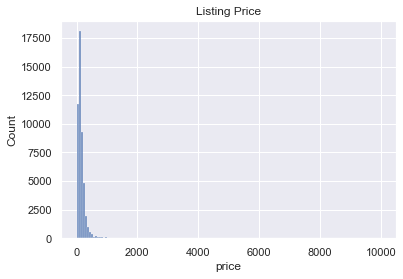

In [20]:
# histogram of all listings price
sns.histplot(data=df, x="price", bins = 150).set(title='Listing Price')

[Text(0.5, 1.0, 'Listings with Price Under $2000')]

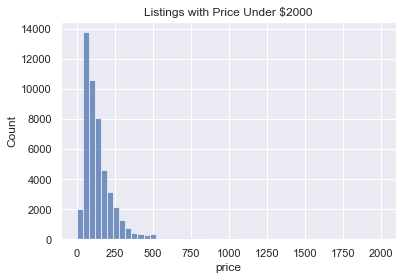

In [21]:
# histogram of listings with price < $2000
sns.histplot(data=df[df['price']<2000], x="price", bins = 50).set(title='Listings with Price Under $2000')

[Text(0.5, 1.0, 'Listings with Price Over $2000')]

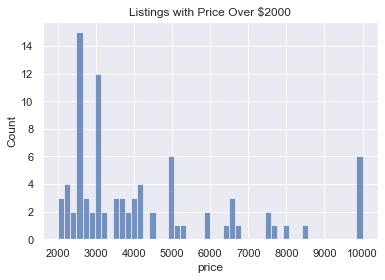

In [22]:
# histogram of listings with price > $2000
sns.histplot(data=df[df['price']>2000], x="price", bins = 50).set(title='Listings with Price Over $2000')

In [23]:
df[df['price']>6000].sort_values('price').head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
29664,22780103,Park Avenue Mansion by (Hidden by Airbnb),156158778,Sally,Manhattan,Upper East Side,40.78517,-73.95270,Entire home/apt,6419,1,0,NaN,NaN,12,45
3774,2271504,SUPER BOWL Brooklyn Duplex Apt!!,11598359,Jonathan,Brooklyn,Clinton Hill,40.68766,-73.96439,Entire home/apt,6500,1,0,NaN,NaN,1,0
37194,29547314,Apartment New York \nHell’s Kitchens,35303743,Patricia,Manhattan,Upper West Side,40.76835,-73.98367,Private room,6500,30,0,NaN,NaN,1,97
48043,36056808,Luxury TriBeCa Apartment at an amazing price,271248669,Jenny,Manhattan,Tribeca,40.71206,-74.00999,Entire home/apt,6500,180,0,NaN,NaN,1,365
44034,33998396,3000 sq ft daylight photo studio,3750764,Kevin,Manhattan,Chelsea,40.75060,-74.00388,Entire home/apt,6800,1,0,NaN,NaN,6,364


We can see that the data is quite skewed with multiple extremely high prices. Further inspecting the names of the listings shows that some of these listings served as photography and filming locations rather than places for lodging. One listing mentions the super bowl which may explain the skewed price. Below we determine which listings are outliers based on listing price.

In [24]:
# using the 1.5 Interquartile Range Test on listing price to determine outliers
IQR = np.percentile(df.price, 75)-np.percentile(df.price, 25)
lower_limit = np.percentile(df.price, 25) - 1.5*IQR
upper_limit = np.percentile(df.price, 75) + 1.5*IQR

print(lower_limit, upper_limit) 

-90.0 334.0


In [25]:
# We will also check our upper and lower limit for values 3 std devs. away from the mean price.
price_std = np.std(df.price)
price_mean = np.mean(df.price)
price_cut_off = price_std * 3

lower_limit2  = price_mean - price_cut_off 
upper_limit2 = price_mean + price_cut_off

print(lower_limit2, upper_limit2) 

-567.7344545714227 873.1758289450804


In [26]:
df.shape

(48895, 16)

In [27]:
df[df.price>874].shape # there are 388 listings that will be counted as outliers

(388, 16)

We looked at the price value of the 1.5 IQR test and listings 3 standard deviations from the mean price to compare upper and lower price listing values. We will consider listings \\$874 or listings 3 std devs. above the mean as outliers. We chose the higher value of 874 since it appears online that listings near the $400 price range are typical for NYC.  

#### Omitting Listings From Dataset

In [28]:
df.shape

(48895, 16)

In [29]:
# remove null listings
df = df.dropna()
df.shape

(38821, 16)

In [30]:
# remove listings that have zero availability (availability_365), zero number_of_reviews, last_review before 2016 
#     and price < $10 or price > $874 

df = df.loc[(df.availability_365 > 0) & (df.number_of_reviews > 0) & (df.last_review > '2016') & 
       (df.price > 10) & (df.price < 874)] 

In [31]:
df.shape # size of cleaned dataset

(25693, 16)

### Exploratory Data Analysis

*We will explore the dataset variables in order to gain a better understanding of the relationships between them. Through our EDA we seek to graphically discover insights into the Airbnb marketplace of 2019.*

Text(0.5, 1.0, 'Room Type Counts')

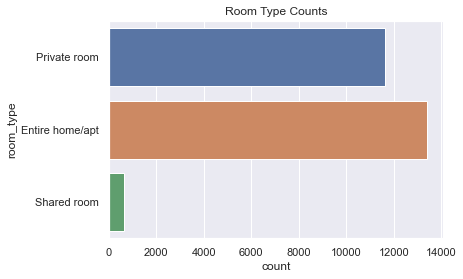

In [32]:
sns.countplot(y = 'room_type', data = df).set_title('Room Type Counts')

We can see that most listings are either private rooms or the entire homes/ apts. This indicates that most Airbnb customers may be looking for private accomodation rather than shared spaces.

Text(0.5, 1.0, 'Count of Listings by Borough')

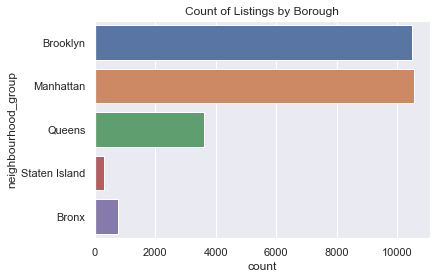

In [33]:
sns.countplot(y = 'neighbourhood_group', data= df).set_title("Count of Listings by Borough")

Most listings are either in the boroughs of Brooklyn or Manhattan. This is logical given that these 2 boroughs contain the most attractions and activites in New York City. Staten Island has the lowest number of listings, which may be due to its geographical location being relatively inaccessible compared to the other boroughs.

Text(0.5, 1.0, 'Count of Listings by Neighborhood')

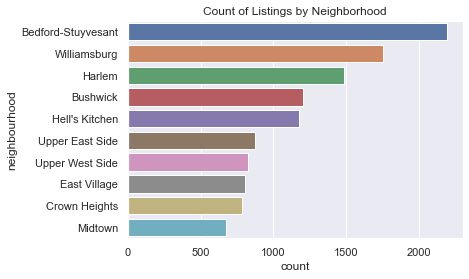

In [34]:
dfn = df['neighbourhood'].value_counts() # counts the amount of listings by neighborhood
sns.countplot(y='neighbourhood', data=df, order=dfn.iloc[:10].index).set_title('Count of Listings by Neighborhood')

The top 4 neighborhoods of Airbnb listings are all in Brooklyn, with Bedford-Stuyvesant being the top neighborhood by a large margin. The 5th to 8th most popular neighborhoods are in Manhattan. This may be due to affordability of Brooklyn compared to Manhattan.

#### Visualizations Based on Price

Text(0.5, 1.0, 'Price Distribution')

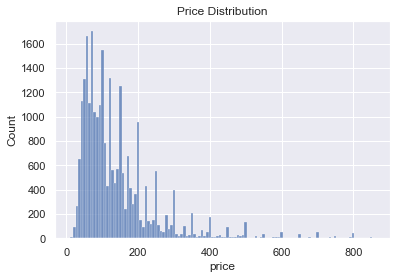

In [35]:
sns.histplot(df, x = 'price').set_title('Price Distribution')

From the histogram above, we can see a left-skewed unimodal distribution. A majority of the listings hover around a price between 35 to 130 USD. However, there are significant spikes at 150, 200, 250, and 300 USD bins, as well as smaller spikes at 175, 225, 275, and 325 USD bins. We believe that this may be caused by human psychology where hosts may round their prices to the nearest 25 or 50 dollar for a more "aesthetically pleasing" price number.

Text(0.5, 0, 'Neighbourhood Group')

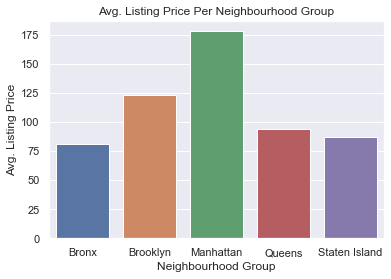

In [36]:
# calculates table of average price of listing per neighbourhood group
df_npg = df[['neighbourhood_group','price']].groupby('neighbourhood_group').mean()
# barplot
sns.barplot(x=df_npg.index, y = 'price', data=df_npg).set_title("Avg. Listing Price Per Neighbourhood Group")
plt.ylabel("Avg. Listing Price")
plt.xlabel("Neighbourhood Group")

We observe that Manhattan has the highest average listing price compared to the other neighbourhood groups. We find that the Bronx and Staten Island's average listing prices are the two lowest. 

Text(0.5, 0, 'Neighbourhood')

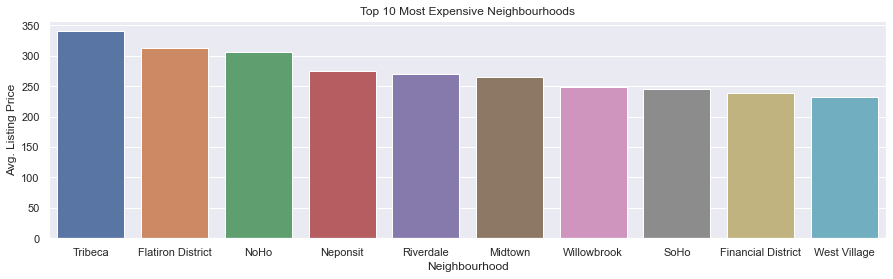

In [37]:
# 10 highest average price neighbourhoods

plt.figure(figsize=(15,4))
# calculates table of average price of listing per neighbourhood 
df_np = df[['neighbourhood','price']].groupby('neighbourhood').mean().sort_values('price',ascending=False)
# barplot
sns.barplot(x=df_np.index, y = 'price', data=df_np, order=df_np.iloc[:10].index).set_title("Top 10 Most Expensive Neighbourhoods")
plt.ylabel("Avg. Listing Price")
plt.xlabel("Neighbourhood")

Text(0.5, 0, 'Neighbourhood')

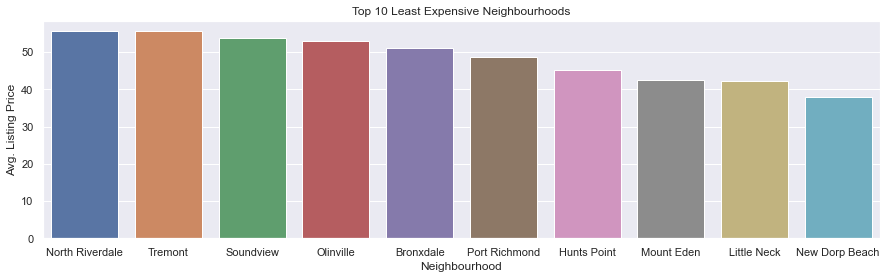

In [38]:
# 10 lowest average price neighbourhoods
plt.figure(figsize=(15,4))
sns.barplot(x=df_np.index, y = 'price', data=df_np, order=df_np.iloc[-10:].index).set_title("Top 10 Least Expensive Neighbourhoods")
plt.ylabel("Avg. Listing Price")
plt.xlabel("Neighbourhood")

In the above two bar plots we are able to view the highest and lowest average listing price per NYC neighbourhood. This information could be beneficial to Airbnb users since they would be able to gauge which NYC neighborhoods are in their price range and search for listings in those areas.

Text(0.5, 1.0, 'Density Map of Airbnb Listings')

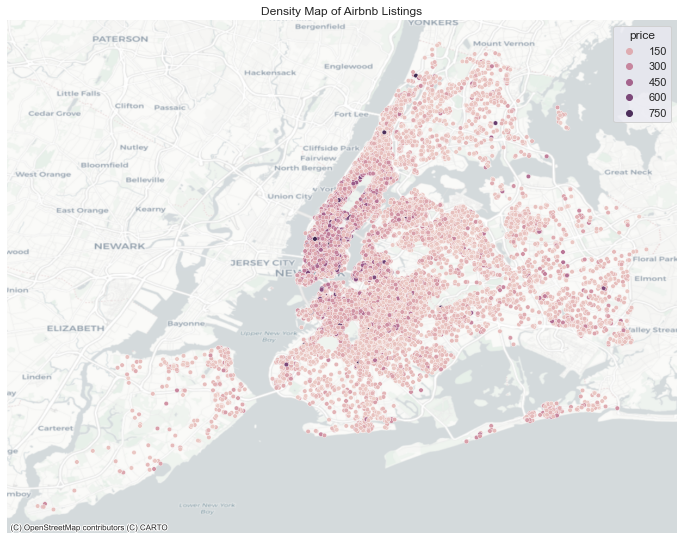

In [39]:
# density map of NYC based on listing price
plt.figure(figsize=(12,24))
sns_map = sns.scatterplot(x='longitude', y='latitude', hue='price',s=20, data=df)
ctx.add_basemap(sns_map, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)
sns_map.set_axis_off()
plt.title('Density Map of Airbnb Listings')

From the density map above, we can see that most of the listings are concentrated around the boroughs of Brooklyn and Manhattan. We can also observe that Manhattan has a higher density of expensive listings, and apart from standout anomalies, prices tend to be lower as listings become further from Manhattan.

*Constructed Map Using*: <https://geopandas.org/gallery/create_geopandas_from_pandas.html>

Text(0.5, 0, 'Price')

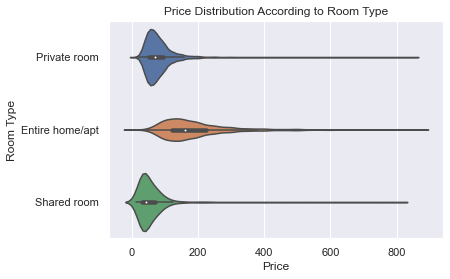

In [40]:
ax = sns.violinplot(y="room_type", x="price", data=df)
plt.title("Price Distribution According to Room Type")
plt.ylabel('Room Type')
plt.xlabel('Price')

The plot above shows the distribution of price by room type. There is much variation in price within each room type. Through this violin plot, we can see that price greatly fluctuates between the type of room. It can be seen that entire home/apt listings tend to be more expensive than both private room and shared room, although private room is more expensive than a shared room. The logic behind the prices seem to make sense.

Text(40.85372673611111, 0.5, 'Price')

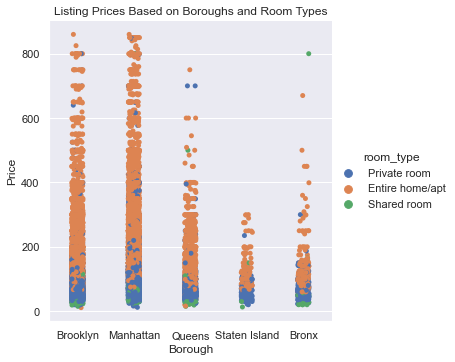

In [41]:
#by room type and borough
sns.catplot(x='neighbourhood_group', y='price', data = df, hue = 'room_type')
plt.title("Listing Prices Based on Boroughs and Room Types")
plt.xlabel("Borough")
plt.ylabel("Price")

The plot above appears to show a trend that shared rooms are the cheapest option in all boroughs, followed by private room and entire property. Additionally, Staten Island and the Bronx have a lot less listings above 150USD compared to Brooklyn and Manhattan. Additionally, as seen in our density map, Manhattan has the highest density of expensive listings compared to other boroughs.

#### Visualizations based Reviews Per Month

By futher exploring reviews per month we are able view to the popularity of listings. In Section 2, of our analysis we will explore the sentiment of the reviews to understand if the reviews left for a listing are postive or negative. 

Text(0.5, 1.0, 'Reviews Per Month Distribution')

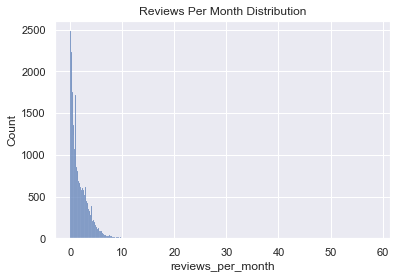

In [42]:
sns.histplot(df, x = 'reviews_per_month').set_title('Reviews Per Month Distribution')

In [43]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [44]:
np.mean(df.reviews_per_month)

1.8333553886272527

The distribution of number of reviews are right skewed. With the listings getting an average of 1.83 reviews per month. Some listings get as many as 58.5 average reviews per month.

In [45]:
df[df.reviews_per_month>20]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
38870,30423106,Lou's Palace-So much for so little,228415932,Louann,Queens,Rosedale,40.65417,-73.74158,Private room,45,1,37,2019-07-08,20.94,1,134
42075,32678719,Enjoy great views of the City in our Deluxe Room!,244361589,Row NYC,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,2019-07-07,58.50,9,299
42076,32678720,Great Room in the heart of Times Square!,244361589,Row NYC,Manhattan,Theater District,40.75828,-73.98876,Private room,199,1,82,2019-07-07,27.95,9,299


Text(38.917191362847234, 0.5, 'Reviews per Month')

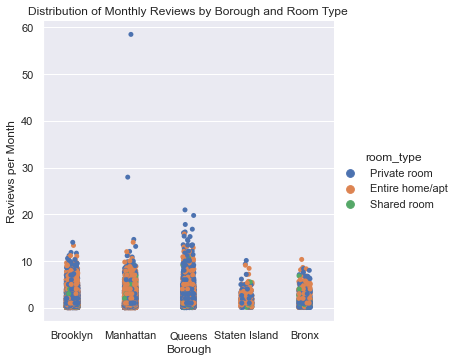

In [46]:
sns.catplot(x='neighbourhood_group', y='reviews_per_month', data = df, hue='room_type')
plt.title('Distribution of Monthly Reviews by Borough and Room Type')
plt.xlabel('Borough')
plt.ylabel('Reviews per Month')

We can see that most boroughs have a similar pattern of reviews per month, with 2 anomalies in Manhattan. Further analysis reveals that both listings (ID: 32678719 and 32678720) are by the same host Row NYC (Host ID: 244361589) which is a hotel in New York City. They may have more reviews as they may be more attractive to customers as an established hotel chain. Additionally, they may have multiple rooms available under the same listing, which would explain why they have listings getting 58.5 reviews in a span of 30 or 31 days. 

***We have completed our Data Cleaning, and EDA sections for the Airbnb NYC 2019 Open Data. We were able to find insights in metrics of listing price and reviews per month which would be beneficial to Airbnb users planning a visit in NYC. In the our next section we will use NLP techniques on the name metric and the listing reviews to find overall sentiment.***

#### Referenced Code 

**Dataset**
- https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

**EDA**
- https://geopandas.org/gallery/create_geopandas_from_pandas.html